In [1]:
import torch
from torch import nn
from torch.nn import Module
import torch.nn.functional as F

In [2]:
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable

In [3]:
import brevitas.nn as qnn
from brevitas.quant import Int8Bias as BiasQuant
from brevitas.export import FINNManager
from brevitas.export import StdQOpONNXManager

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time

In [5]:
start_time = time.time()

In [6]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [7]:
data_train = torchvision.datasets.MNIST('./data/', 
                                        train=True, download=True,
                                        transform=torchvision.transforms.Compose
                                        ([
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                        ]))
data_test = torchvision.datasets.MNIST('./data/', 
                                       train=False, download=True,
                                       transform=torchvision.transforms.Compose
                                       ([
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                       ]))

In [8]:
data_loader_train = torch.utils.data.DataLoader(dataset=data_train,
                                                batch_size=batch_size_train, 
                                                shuffle=True)

In [9]:
data_loader_test = torch.utils.data.DataLoader(dataset=data_test,
                                               batch_size=batch_size_test, 
                                               shuffle=True)

In [10]:
examples = enumerate(data_loader_test)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([1000, 1, 28, 28])

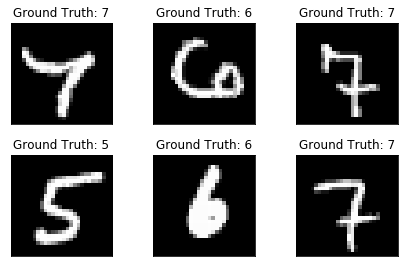

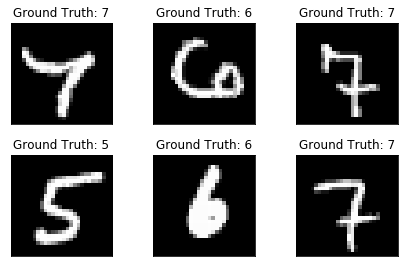

In [11]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [12]:
class LowPrecisionMLP(Module):
    def __init__(self):
        super(LowPrecisionMLP, self).__init__()
        self.quant_inp = qnn.QuantIdentity(
            bit_width=8, return_quant_tensor=True)
        self.fc1   = qnn.QuantLinear(
            1*28*28, 32, bias=True, weight_bit_width=8, bias_quant=BiasQuant, return_quant_tensor=True)
        self.relu1 = qnn.QuantReLU(
            bit_width=8, return_quant_tensor=True)
        self.fc2   = qnn.QuantLinear(
            32, 32, bias=True, weight_bit_width=8, bias_quant=BiasQuant, return_quant_tensor=True)
        self.relu2 = qnn.QuantReLU(
            bit_width=8, return_quant_tensor=True)
        self.fc3   = qnn.QuantLinear(
            32, 32, bias=True, weight_bit_width=8, bias_quant=BiasQuant, return_quant_tensor=True)
        self.relu3 = qnn.QuantReLU(
            bit_width=8, return_quant_tensor=True)
        self.fc4   = qnn.QuantLinear(
            32, 10, bias=False, weight_bit_width=8)

    def forward(self, x):
        out = self.quant_inp(x)
        out = out.reshape(out.shape[0], -1)
        out = self.relu1(self.fc1(out))
        out = self.relu2(self.fc2(out))
        out = self.relu3(self.fc3(out))
        out = self.fc4(out)
        return out

In [13]:
low_precision_mlp = LowPrecisionMLP()

In [14]:
cost=torch.nn.CrossEntropyLoss()

In [15]:
optimizer = torch.optim.Adam(low_precision_mlp.parameters())

In [16]:
# 卷积神经网络模型进行模型训练和参数优化的代码
n_epochs = 5
 
for epoch in range(n_epochs):
    running_loss = 0.0
    running_correct = 0
    print("Epoch  {}/{}".format(epoch, n_epochs))
    print("-"*10)
    for data in data_loader_train:
        X_train , y_train = data
        # 有GPU加下面这行，没有不用加
        # X_train, y_train = X_train.cuda(), y_train.cuda()
        X_train , y_train = Variable(X_train),Variable(y_train)
        # print(y_train)
        outputs = low_precision_mlp(X_train)
        # print(outputs)
        _,pred = torch.max(outputs.data,1)
        optimizer.zero_grad()
        loss = cost(outputs,y_train)
 
        loss.backward()
        optimizer.step()
        # running_loss += loss.data[0]
        running_loss += loss.item()
        running_correct += torch.sum(pred == y_train.data)
        # print("ok")
        # print("**************%s"%running_corrrect)
 
    print("train ok ")
    testing_correct = 0
    for data in data_loader_test:
        X_test,y_test = data
        # 有GPU加下面这行，没有不用加
        # X_test, y_test = X_test.cuda(), y_test.cuda()
        X_test,y_test = Variable(X_test),Variable(y_test)
        outputs = low_precision_mlp(X_test)
        _, pred = torch.max(outputs,1)
        testing_correct += torch.sum(pred == y_test.data)
        # print(testing_correct)
 
    print( "Loss is :{:.4f},Train Accuracy is:{:.4f}%,Test Accuracy is:{:.4f}".format(
                 running_loss / len(data_train),100 * running_correct / len(data_train),
                 100 * testing_correct / len(data_test)))

Epoch  0/5
----------
train ok 


/opt/conda/conda-bld/pytorch_1591914855613/work/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


Loss is :0.0062,Train Accuracy is:88.0000%,Test Accuracy is:93.0000
Epoch  1/5
----------
train ok 
Loss is :0.0029,Train Accuracy is:94.0000%,Test Accuracy is:95.0000
Epoch  2/5
----------
train ok 
Loss is :0.0023,Train Accuracy is:95.0000%,Test Accuracy is:95.0000
Epoch  3/5
----------
train ok 
Loss is :0.0019,Train Accuracy is:96.0000%,Test Accuracy is:95.0000
Epoch  4/5
----------
train ok 
Loss is :0.0017,Train Accuracy is:96.0000%,Test Accuracy is:95.0000


In [17]:
stop_time = time.time()
print("time is %s" %(stop_time-start_time))

time is 88.906085729599


In [18]:
FINNManager.export(low_precision_mlp, input_shape=(1, 28, 28), export_path='finn_mlp_w8a8.onnx')

ir_version: 6
producer_name: "pytorch"
producer_version: "1.5"
graph {
  node {
    input: "inp.1"
    input: "12"
    output: "13"
    name: "MultiThreshold_1"
    op_type: "MultiThreshold"
    attribute {
      name: "out_dtype"
      s: "INT8"
      type: STRING
    }
    domain: "finn.custom_op.general"
  }
  node {
    input: "13"
    input: "14"
    output: "15"
    name: "Add_3"
    op_type: "Add"
    domain: ""
  }
  node {
    input: "15"
    input: "16"
    output: "17"
    name: "Mul_5"
    op_type: "Mul"
  }
  node {
    input: "17"
    output: "18"
    name: "Shape_6"
    op_type: "Shape"
  }
  node {
    input: "18"
    input: "19"
    output: "20"
    name: "Gather_8"
    op_type: "Gather"
    attribute {
      name: "axis"
      i: 0
      type: INT
    }
  }
  node {
    input: "20"
    output: "22"
    name: "Unsqueeze_9"
    op_type: "Unsqueeze"
    attribute {
      name: "axes"
      ints: 0
      type: INTS
    }
  }
  node {
    input: "22"
    input: "72"
    ou

In [19]:
StdQOpONNXManager.export(low_precision_mlp, input_shape=(1, 28, 28), export_path='onnx_mlp_w8a8.onnx')

ir_version: 6
producer_name: "pytorch"
producer_version: "1.5"
graph {
  node {
    output: "12"
    name: "Constant_0"
    op_type: "Constant"
    attribute {
      name: "value"
      t {
        dims: 28
        dims: 255
        data_type: 1
        raw_data: "&\0346\300\200\2564\300\332@3\3004\3231\300\216e0\300\350\367.\300B\212-\300\234\034,\300\366\256*\300PA)\300\253\323\'\300\005f&\300_\370$\300\271\212#\300\023\035\"\300m\257 \300\307A\037\300!\324\035\300{f\034\300\325\370\032\300/\213\031\300\211\035\030\300\343\257\026\300=B\025\300\227\324\023\300\361f\022\300L\371\020\300\246\213\017\300\000\036\016\300Z\260\014\300\264B\013\300\016\325\t\300hg\010\300\302\371\006\300\034\214\005\300v\036\004\300\320\260\002\300*C\001\300\010\253\377\277\274\317\374\277p\364\371\277$\031\367\277\330=\364\277\214b\361\277A\207\356\277\365\253\353\277\251\320\350\277]\365\345\277\021\032\343\277\305>\340\277yc\335\277.\210\332\277\342\254\327\277\226\321\324\277J\366\321\277\376\032\317\2